# **Installisions**

In [1]:
h

NameError: name 'h' is not defined

In [2]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 86.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstall

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

2025-12-18 09:50:43.996554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766051444.187352      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766051444.240693      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'
file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=02dfb580-e13f-4abf-a310-7827f5f1a00a
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:07<00:00, 109MB/s]  


'sepsis_data.csv'

In [5]:
def load_and_preprocess_data(filepath):
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns
                  if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])
    cols_to_drop = [col for col in df.columns if 'observed' in col.lower()]
    cols_to_drop.extend(['HospAdmTime', 'Age'])
    cols_to_drop = list(set([col for col in cols_to_drop if col in df.columns]))
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())
    df[cols_to_impute] = df[cols_to_impute].fillna(0)
    return df

In [6]:
df = load_and_preprocess_data("/kaggle/working/sepsis_data.csv")

In [7]:
def create_patient_sequences(df, sequence_length=10):
    try:
        sequences = []
        labels = []
        
        feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]
        
        for pid, group in df.groupby('Patient_ID'):
            features = group[feature_cols].values
            sepsis_labels = group['SepsisLabel'].values
            
            if len(features) < sequence_length:
                pad_len = sequence_length - len(features)
                features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
                sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])
            
            for i in range(0, len(features) - sequence_length + 1, 1):
                seq = features[i:i+sequence_length]
                label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
                sequences.append(seq)
                labels.append(label)
        
        X = np.array(sequences, dtype=np.float32)
        y = np.array(labels, dtype=np.int8)
        
        print(f"Created {len(X)} sequences")
        print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
        return X, y, feature_cols
    except Exception as e:
        print(f"Error in create_patient_sequences: {e}")
        raise
X, y, feature_cols = create_patient_sequences(df, sequence_length=10)

Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


In [15]:
def decision_tree_undersampling(X, y, target_samples=35000):
    try:
        print(f"\nUndersampling majority class to {target_samples} samples...")
        
        majority_indices = np.where(y == 0)[0]
        
        if len(majority_indices) <= target_samples:
            return X, y
        
        np.random.shuffle(majority_indices)
        subset_indices = majority_indices[:min(50000, len(majority_indices))]
        
        X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y[subset_indices], X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        sample_importances = dt.feature_importances_.sum()
        selected_indices = np.random.choice(subset_indices, size=target_samples, replace=False)
        
        minority_indices = np.where(y == 1)[0]
        final_indices = np.concatenate([selected_indices, minority_indices])
        
        return X[final_indices], y[final_indices]
    except Exception as e:
        print(f"Error in decision_tree_undersampling: {e}")
        raise

In [16]:
def decision_tree_upsampling(X, y, target_samples=27000):
    try:
        print(f"\nUpsampling minority class to {target_samples} samples...")
        
        minority_indices = np.where(y == 1)[0]
        
        if len(minority_indices) >= target_samples:
            return X, y
        
        num_to_generate = target_samples - len(minority_indices)
        
        X_flattened = X.reshape(-1, X.shape[-1])
        y_flattened = np.repeat(y, X.shape[1])
        
        dt = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt.fit(X_flattened, y_flattened)
        
        synthetic_samples = []
        for _ in range(num_to_generate):
            base_sample = X[np.random.choice(minority_indices)]
            
            synthetic_sample = base_sample.copy()
            for t in range(X.shape[1]):
                for f in range(X.shape[2]):
                    if dt.feature_importances_[f] > 0.01:
                        noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                        synthetic_sample[t, f] += noise
            
            synthetic_samples.append(synthetic_sample)
        
        synthetic_samples = np.array(synthetic_samples)
        
        X_upsampled = np.concatenate([X, synthetic_samples])
        y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])
        
        return X_upsampled, y_upsampled
    except Exception as e:
        print(f"Error in decision_tree_upsampling: {e}")
        raise

In [10]:
X, y = decision_tree_undersampling(X, y, target_samples=35000)
X, y = decision_tree_upsampling(X, y, target_samples=27000)


Undersampling majority class to 35000 samples...

Upsampling minority class to 27000 samples...


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [18]:
def build_resnet_model(input_shape, dropout_rate=0.3, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    def res_block(x, filters):
        shortcut = x
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
        
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        
        if shortcut.shape[-1] != filters:
            shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)
        
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x
    
    x = res_block(x, 64)
    x = res_block(x, 128)
    x = res_block(x, 128)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model


I0000 00:00:1762246736.434938      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1762246745.799662     133 service.cc:148] XLA service 0x7d9bbc001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762246745.800533     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762246746.679849     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


  38/1240 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5588 - auc: 0.5517 - loss: 0.7621 

I0000 00:00:1762246751.887384     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.6505 - auc: 0.6926 - loss: 0.6348 - val_accuracy: 0.7140 - val_auc: 0.7843 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 2/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7030 - auc: 0.7631 - loss: 0.5769 - val_accuracy: 0.7248 - val_auc: 0.7991 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 3/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7204 - auc: 0.7868 - loss: 0.5531 - val_accuracy: 0.7377 - val_auc: 0.8140 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 4/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7378 - auc: 0.8074 - loss: 0.5290 - val_accuracy: 0.7439 - val_auc: 0.8204 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 5/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7504 - auc: 0.8240 - loss: 0.5092 - val_accuracy: 0.7529 - val_auc: 0.8333 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 6/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7639 - auc: 

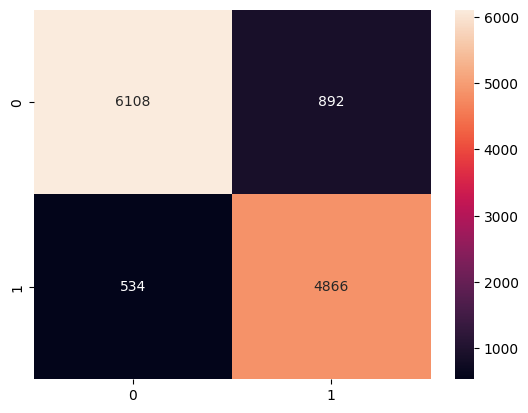

In [15]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_resnet_model(input_shape)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluation
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import time

np.random.seed(42)
minority_indices = np.where(y == 1)[0]
majority_indices = np.where(y == 0)[0]
n_minority = len(minority_indices)

n_minority_half = n_minority // 2
selected_minority = np.random.choice(minority_indices, size=n_minority_half, replace=False)
selected_majority = np.random.choice(majority_indices, size=n_minority_half, replace=False)

subset_indices = np.concatenate([selected_minority, selected_majority])
np.random.shuffle(subset_indices)
X_subset = X[subset_indices]
y_subset = y[subset_indices]
print(f"Subset created: {len(X_subset)} samples (balanced, 50% of original)")

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42
)
X_train_sub_scaled = scaler.transform(X_train_sub.reshape(-1, X_train_sub.shape[-1])).reshape(X_train_sub.shape)
X_val_sub_scaled = scaler.transform(X_val_sub.reshape(-1, X_val_sub.shape[-1])).reshape(X_val_sub.shape)

def generate_neighbors(current, bounds, step_size=0.05):
    neighbors = []
    for i in range(len(current)):
        for delta in [-step_size, step_size]:
            neighbor = current.copy()
            neighbor[i] = np.clip(neighbor[i] + delta, bounds[i, 0], bounds[i, 1])
            neighbors.append(neighbor)
    return neighbors

def tabu_search(objective, bounds, n_iterations=5, tabu_size=3, step_size=0.05, verbose=False):
    current = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
    current_eval = objective(current)
    
    best = current.copy()
    best_eval = current_eval
    
    tabu_list = []
    
    for iteration in range(n_iterations):
        neighbors = generate_neighbors(current, bounds, step_size)
        best_neighbor = None
        best_neighbor_eval = float('inf')
        
        for neighbor in neighbors:
            neighbor_tuple = tuple(np.round(neighbor, 6))
            
            if neighbor_tuple in tabu_list:
                continue
            eval_val = objective(neighbor)
            if eval_val < best_neighbor_eval:
                best_neighbor = neighbor
                best_neighbor_eval = eval_val
        
        if best_neighbor is None:
            break
        
        current = best_neighbor
        current_eval = best_neighbor_eval
        
        current_tuple = tuple(np.round(current, 6))
        if current_eval < best_eval:
            best = current.copy()
            best_eval = current_eval
            if verbose:
                print(f"  Tabu {iteration+1}/{n_iterations} | Loss: {best_eval:.4f}")
        
        tabu_list.append(current_tuple)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
    
    return best, best_eval

def objective_function_subset(params):
    dropout_rate, learning_rate = params
    model = build_resnet_model(
        input_shape=(X_train_sub.shape[1], X_train_sub.shape[2]),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train_sub_scaled, y_train_sub,
        validation_data=(X_val_sub_scaled, y_val_sub),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    del model
    tf.keras.backend.clear_session()
    return val_loss

def tabu_search_meta_objective(tabu_params):
    n_iterations, tabu_size, step_size = tabu_params
    n_iterations = int(n_iterations)
    tabu_size = int(tabu_size)
    
    print(f"\n  [Testing Tabu params: n_iter={n_iterations}, size={tabu_size}, step={step_size:.4f}]")
    
    model_bounds = np.array([[0.1, 0.5], [0.0001, 0.01]])
    
    best_params, best_loss = tabu_search(
        objective_function_subset,
        model_bounds,
        n_iterations=n_iterations,
        tabu_size=tabu_size,
        step_size=step_size,
        verbose=True
    )
    
    print(f"  [Tabu finished: best_loss={best_loss:.4f}]")
    
    return best_loss

def simulated_annealing(objective, bounds, n_iterations=5, temp=3.0, cooling_rate=0.9):
    current = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
    current_eval = objective(current)
    
    best = current.copy()
    best_eval = current_eval
    
    print(f"SA Initial | Val Loss: {current_eval:.4f} | n_iter: {int(current[0])}, tabu_size: {int(current[1])}, step: {current[2]:.4f}")
    
    for i in range(n_iterations):
        iter_start = time.time()
        
        candidate = current + np.random.normal(0, 0.1, size=len(bounds))
        candidate = np.clip(candidate, bounds[:, 0], bounds[:, 1])
        
        candidate_eval = objective(candidate)
        
        iter_time = time.time() - iter_start
        
        if candidate_eval < current_eval:
            current, current_eval = candidate, candidate_eval
            if candidate_eval < best_eval:
                best, best_eval = candidate, candidate_eval
                print(f"SA Iter {i+1}/{n_iterations} | NEW BEST: {best_eval:.4f} | n_iter: {int(best[0])}, tabu_size: {int(best[1])}, step: {best[2]:.4f} | Time: {iter_time:.1f}s")
        else:
            prob = np.exp((current_eval - candidate_eval) / temp)
            if np.random.rand() < prob:
                current, current_eval = candidate, candidate_eval
                print(f"SA Iter {i+1}/{n_iterations} | Accepted worse | Val Loss: {current_eval:.4f} | Temp: {temp:.2f} | Time: {iter_time:.1f}s")
            else:
                print(f"SA Iter {i+1}/{n_iterations} | Rejected | Val Loss: {candidate_eval:.4f} | Time: {iter_time:.1f}s")
        
        temp *= cooling_rate
    
    return best, best_eval

tabu_bounds = np.array([
    [3, 5],
    [2, 3],
    [0.03, 0.07]
])

print("Starting Simulated Annealing to optimize Tabu Search parameters...")
print("="*70)

best_tabu_params, best_meta_loss = simulated_annealing(
    tabu_search_meta_objective,
    tabu_bounds,
    n_iterations=5,
    temp=3.0,
    cooling_rate=0.9
)

print("="*70)
print(f"\nOptimization Complete!")
print(f"Best Tabu Search Parameters:")
print(f"  n_iterations: {int(best_tabu_params[0])}")
print(f"  tabu_size: {int(best_tabu_params[1])}")
print(f"  step_size: {best_tabu_params[2]:.4f}")
print(f"Best Validation Loss: {best_meta_loss:.4f}")

print("\n" + "="*70)
print("Final Run: Using optimized Tabu Search parameters on full training")
print("="*70)

model_bounds = np.array([[0.1, 0.5], [0.0001, 0.01]])

final_best_params, final_best_loss = tabu_search(
    objective_function_subset,
    model_bounds,
    n_iterations=int(best_tabu_params[0]),
    tabu_size=int(best_tabu_params[1]),
    step_size=best_tabu_params[2],
    verbose=True
)

print(f"\nFinal Optimized Model Parameters:")
print(f"  Dropout Rate: {final_best_params[0]:.4f}")
print(f"  Learning Rate: {final_best_params[1]:.6f}")
print(f"Final Validation Loss: {final_best_loss:.4f}")

Subset created: 27000 samples (balanced, 50% of original)
Starting Simulated Annealing to optimize Tabu Search parameters...

  [Testing Tabu params: n_iter=3, size=2, step=0.0442]


In [16]:
def objective_function(params):
    dropout_rate, learning_rate = params
    model = build_resnet_model(input_shape, dropout_rate=dropout_rate, learning_rate=learning_rate)
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=20,  # Reduced epochs for optimization
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

In [19]:
def simulated_annealing(objective, bounds, n_iterations=10, temp=10.0, cooling_rate=0.99):
    current = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
    current_eval = objective(current)
    
    best = current.copy()
    best_eval = current_eval
    
    for i in range(n_iterations):
        # Generate candidate
        candidate = current + np.random.normal(0, 0.1, size=len(bounds))
        candidate = np.clip(candidate, bounds[:, 0], bounds[:, 1])
        
        candidate_eval = objective(candidate)
        if candidate_eval < current_eval:
            current, current_eval = candidate, candidate_eval
            if candidate_eval < best_eval:
                best, best_eval = candidate, candidate_eval
        else:
            prob = np.exp((current_eval - candidate_eval) / temp)
            if np.random.rand() < prob:
                current, current_eval = candidate, candidate_eval
        
        temp *= cooling_rate
    
    return best, best_eval

In [20]:
bounds = np.array([[0.1, 0.5], [1e-5, 1e-2]])
best_params_sa, best_score_sa = simulated_annealing(objective_function, bounds)
print(f"Best params (SA): Dropout={best_params_sa[0]}, LR={best_params_sa[1]}, Score={best_score_sa}")

# Train and Evaluate with SA Optimized Params
model_sa = build_resnet_model(input_shape, dropout_rate=best_params_sa[0], learning_rate=best_params_sa[1])
history_sa = model_sa.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Best params (SA): Dropout=0.4986430825833923, LR=0.01, Score=0.44215190410614014
Epoch 1/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6072 - auc_28: 0.6461 - loss: 0.6626 - val_accuracy: 0.6845 - val_auc_28: 0.7365 - val_loss: 0.6059 - learning_rate: 0.0100
Epoch 2/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6695 - auc_28: 0.7113 - loss: 0.6169 - val_accuracy: 0.6963 - val_auc_28: 0.7622 - val_loss: 0.5781 - learning_rate: 0.0100
Epoch 3/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6849 - auc_28: 0.7373 - loss: 0.5983 - val_accuracy: 0.7095 - val_auc_28: 0.7755 - val_loss: 0.5624 - learning_rate: 0.0100
Epoch 4/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7002 - auc_28: 0.7550 - loss: 0.5803 - val_accuracy: 0.7206 - val_auc_28: 0.7884 - val_loss: 0.5493 - learning_rate: 0.0100
Epoch 5/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7117 - auc_28: 0.7712 - loss: 0.5653 - val_accuracy: 0.7126 - val_auc_28: 0.7836 -

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      7000
           1       0.71      0.82      0.76      5400

    accuracy                           0.77     12400
   macro avg       0.77      0.78      0.77     12400
weighted avg       0.78      0.77      0.77     12400

ROC AUC (SA): 0.7787777777777778


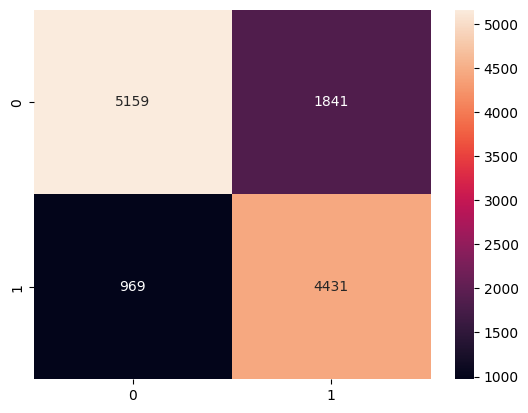

In [21]:
y_pred_sa = (model_sa.predict(X_test_scaled) > 0.5).astype(int)
print(classification_report(y_test, y_pred_sa))
print(f"ROC AUC (SA): {roc_auc_score(y_test, y_pred_sa)}")

cm_sa = confusion_matrix(y_test, y_pred_sa)
sns.heatmap(cm_sa, annot=True, fmt='d')
plt.show()

# **sampling code**

In [13]:
np.random.seed(42)
minority_indices = np.where(y == 1)[0]
majority_indices = np.where(y == 0)[0]

# Take all minority + equal number from majority
n_minority = len(minority_indices)
selected_majority = np.random.choice(majority_indices, size=n_minority, replace=False)

subset_indices = np.concatenate([minority_indices, selected_majority])
np.random.shuffle(subset_indices)

X_subset = X[subset_indices]
y_subset = y[subset_indices]

print(f"Subset created: {len(X_subset)} samples (balanced)")



Subset created: 54000 samples (balanced)


In [14]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42
)
X_train_sub_scaled = scaler.transform(X_train_sub.reshape(-1, X_train_sub.shape[-1])).reshape(X_train_sub.shape)
X_val_sub_scaled = scaler.transform(X_val_sub.reshape(-1, X_val_sub.shape[-1])).reshape(X_val_sub.shape)


In [15]:
def objective_function_subset(params):
    dropout_rate, learning_rate = params
    model = build_resnet_model(
        input_shape=(X_train_sub.shape[1], X_train_sub.shape[2]),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train_sub_scaled, y_train_sub,
        validation_data=(X_val_sub_scaled, y_val_sub),
        epochs=15,  # Fast training
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    del model  # Free memory
    tf.keras.backend.clear_session()
    return val_loss

In [16]:
def generate_neighbors(current, bounds, step_size=0.05):
    neighbors = []
    for i in range(len(current)):
        for delta in [-step_size, step_size]:
            neighbor = current.copy()
            neighbor[i] = np.clip(neighbor[i] + delta, bounds[i, 0], bounds[i, 1])
            neighbors.append(neighbor)
    return neighbors

In [17]:
def tabu_search(objective, bounds, n_iterations=10, tabu_size=5, step_size=0.05):
    current = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
    current_eval = objective(current)
    
    best = current.copy()
    best_eval = current_eval
    
    tabu_list = []  
    
    for iteration in range(n_iterations):
        neighbors = generate_neighbors(current, bounds, step_size)
        best_neighbor = None
        best_neighbor_eval = float('inf')
        
        for neighbor in neighbors:
            neighbor_tuple = tuple(np.round(neighbor, 6)) 
            
            if neighbor_tuple in tabu_list:
                continue 
            eval_val = objective(neighbor)
            if eval_val < best_neighbor_eval:
                best_neighbor = neighbor
                best_neighbor_eval = eval_val
        
        if best_neighbor is None:
            print(f"Iteration {iteration}: No valid non-tabu neighbor. Breaking.")
            break
        
        current = best_neighbor
        current_eval = best_neighbor_eval
        
        current_tuple = tuple(np.round(current, 6))
        if current_eval < best_eval:
            best = current.copy()
            best_eval = current_eval
        
        tabu_list.append(current_tuple)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
        
        print(f"Iter {iteration+1}/10 | Val Loss: {current_eval:.4f} | "
              f"Dropout: {current[0]:.3f}, LR: {current[1]:.6f} | "
              f"Best: {best_eval:.4f}")
    
    return best, best_eval

In [18]:
bounds = np.array([[0.1, 0.5],[1e-5, 1e-2]])


In [19]:
print("\nStarting Tabu Search (10 iterations on 1000-patient subset)...\n")
best_params_ts, best_score_ts = tabu_search(
    objective=objective_function_subset,
    bounds=bounds,
    n_iterations=10,
    tabu_size=5,
    step_size=0.05
)



Starting Tabu Search (10 iterations on 1000-patient subset)...



I0000 00:00:1762253513.524572      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762253513.525278      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1762253523.635796     124 service.cc:148] XLA service 0x7870800243e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762253523.636351     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762253523.636368     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762253524.509026     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762253530.143957     124 device_compiler.h:188] Compiled clust

Iter 1/10 | Val Loss: 0.3544 | Dropout: 0.203, LR: 0.000670 | Best: 0.3544
Iter 2/10 | Val Loss: 0.3534 | Dropout: 0.153, LR: 0.000670 | Best: 0.3534
Iter 3/10 | Val Loss: 0.3774 | Dropout: 0.103, LR: 0.000670 | Best: 0.3534
Iter 4/10 | Val Loss: 0.3672 | Dropout: 0.100, LR: 0.000670 | Best: 0.3534
Iter 5/10 | Val Loss: 0.3571 | Dropout: 0.150, LR: 0.000670 | Best: 0.3534
Iter 6/10 | Val Loss: 0.3426 | Dropout: 0.200, LR: 0.000670 | Best: 0.3426
Iter 7/10 | Val Loss: 0.3739 | Dropout: 0.250, LR: 0.000670 | Best: 0.3426
Iter 8/10 | Val Loss: 0.3834 | Dropout: 0.300, LR: 0.000670 | Best: 0.3426
Iter 9/10 | Val Loss: 0.3989 | Dropout: 0.350, LR: 0.000670 | Best: 0.3426
Iter 10/10 | Val Loss: 0.4071 | Dropout: 0.400, LR: 0.000670 | Best: 0.3426



Best Hyperparameters (Tabu Search):
   Dropout Rate : 0.2000
   Learning Rate: 0.000670
   Best Val Loss: 0.3426

Training final model with Tabu-optimized hyperparameters on full dataset...
Epoch 1/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6580 - auc_2: 0.6999 - loss: 0.6265 - val_accuracy: 0.7144 - val_auc_2: 0.7828 - val_loss: 0.5562 - learning_rate: 6.6951e-04
Epoch 2/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7053 - auc_2: 0.7693 - loss: 0.5693 - val_accuracy: 0.7322 - val_auc_2: 0.8027 - val_loss: 0.5344 - learning_rate: 6.6951e-04
Epoch 3/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7312 - auc_2: 0.7963 - loss: 0.5412 - val_accuracy: 0.7401 - val_auc_2: 0.8174 - val_loss: 0.5188 - learning_rate: 6.6951e-04
Epoch 4/50
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7474 - auc_2: 0.8182 - loss: 0.5157 - val_accuracy: 0.7455 - val_auc_2: 0.8222 - val_loss: 0.5126 - learning_rate: 6.6951e-04
Epoch 5/50
1240/1240 ━━━━━━━━━━━

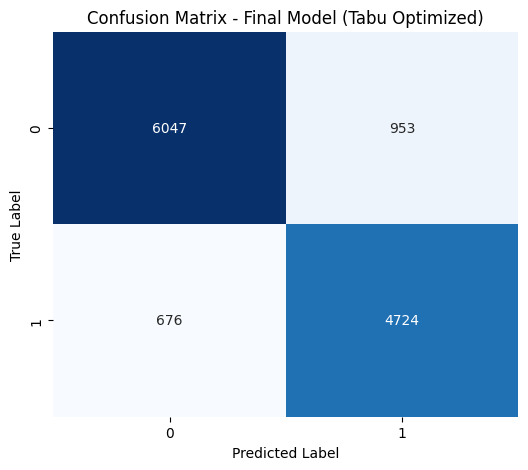

In [22]:






print(f"\nBest Hyperparameters (Tabu Search):")
print(f"   Dropout Rate : {best_params_ts[0]:.4f}")
print(f"   Learning Rate: {best_params_ts[1]:.6f}")
print(f"   Best Val Loss: {best_score_ts:.4f}")

print("\nTraining final model with Tabu-optimized hyperparameters on full dataset...")

model_final = build_resnet_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    dropout_rate=best_params_ts[0],
    learning_rate=best_params_ts[1]
)

callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history_final = model_final.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_final,
    verbose=1
)

y_pred_final = (model_final.predict(X_test_scaled) > 0.5).astype(int)

print("\n" + "="*50)
print("FINAL MODEL EVALUATION (Tabu-Optimized)")
print("="*50)
print(classification_report(y_test, y_pred_final, digits=4))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_final):.4f}")

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Final Model (Tabu Optimized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()